# Baseline

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

Este avance consiste en construir un modelo de referencia que permita evaluar la viabilidad del problema. Si el baseline tiene un rendimiento similar al azar, podría indicar que el problema es intrínsecamente difícil o que los datos no contienen suficiente información para predecir el objetivo. De lo contrario, el baseline podría como una solución mínima aceptable cuando se trabaja en escenarios donde incluso un modelo simple puede proporcionar valor.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, det_curve

from xgboost import XGBClassifier
import shap
from shap import KernelExplainer, summary_plot
import warnings

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

Carga inicial de los datos:

Estos datos fueron procesados en la entrega pasada, usando los mismos pasos salvo a unos cuantas modificaciones necesarias para esta entrega.

Estos datos fueron nuevamente guardados en archivos .parquet que simplemente fueron cargados para facilitar su uso en futuras integraciones.

In [5]:
def cargar_datos():
    """
    Carga los datos preprocesados del análisis exploratorio
    """
    X_train = pd.read_parquet('/content/data/preprocessed/X_train.parquet')
    y_train = pd.read_parquet('/content/data/preprocessed/y_train.parquet')
    X_val = pd.read_parquet('/content/data/preprocessed/X_val.parquet')
    y_val = pd.read_parquet('/content/data/preprocessed/y_val.parquet')
    X_test = pd.read_parquet('/content/data/preprocessed/X_test.parquet')
    y_test = pd.read_parquet('/content/data/preprocessed/y_test.parquet')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_text, y_test = cargar_datos()

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 4), (571, 3), (556, 4), (556, 3))

# Análisis de balance de clases

El balanceo de clases es una parte crucial en proyectos de IA y ML porque garantiza que su modelo aprenda de manera efectiva y haga predicciones justas e imparciales.


Gráficas de nuestras etiquetas de depresión, ansiedad y estrés

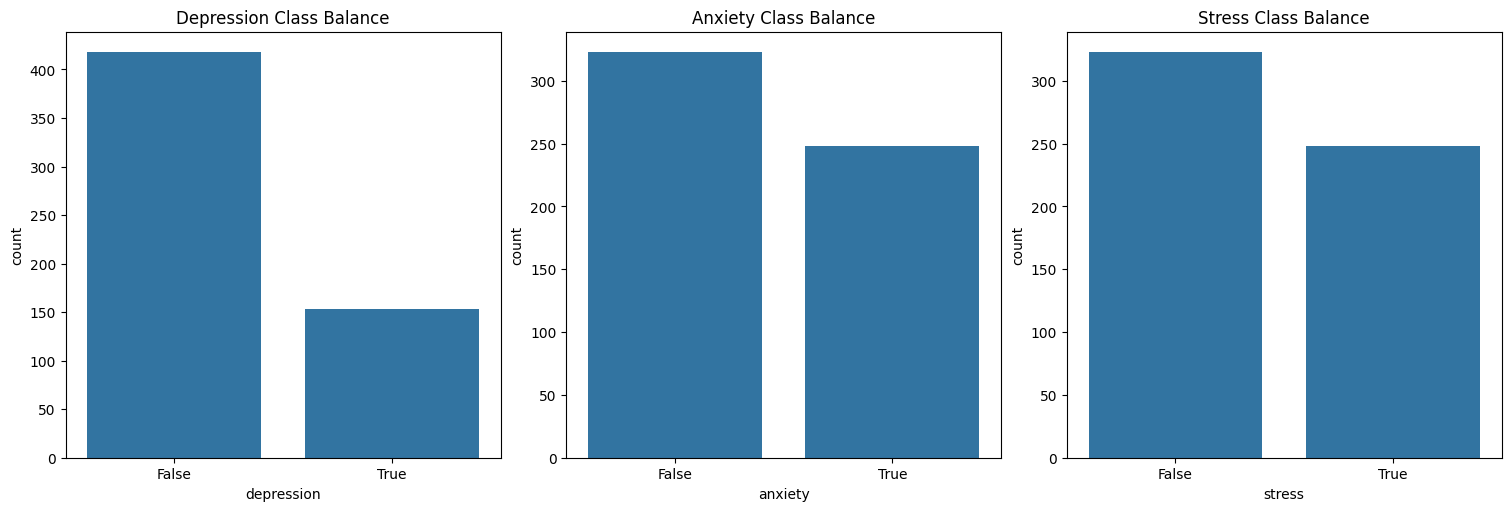

Porcentaje de la clase positiva de Depression: 0.27
Porcentaje de la clase positiva de Anxiety: 0.43
Porcentaje de la clase positiva de Stress: 0.43


In [8]:
# Set up the figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
sns.countplot(data=y_train, x='depression', ax=axes[0])
axes[0].set_title('Depression Class Balance')
sns.countplot(data=y_train, x='anxiety', ax=axes[1])
axes[1].set_title('Anxiety Class Balance')
sns.countplot(data=y_train, x='stress', ax=axes[2])
axes[2].set_title('Stress Class Balance')
plt.show()

# Print proportions
print(f'Porcentaje de la clase positiva de Depression: {y_train["depression"].mean():.2f}')
print(f'Porcentaje de la clase positiva de Anxiety: {y_train["anxiety"].mean():.2f}')
print(f'Porcentaje de la clase positiva de Stress: {y_train["stress"].mean():.2f}')


Primeramente podemos comprobar que existe un balance entre las etiquetas de ansiedad y estrés, depresión del otro lado, se encuentra ligeramente menos balanceado comparado con las otras 2, tendiendo mas al lado negativo.

In [9]:
print(f"Expected minimum accuracy for depression: {y_train['depression'].mean():.4f}")
print(f"Expected minimuma ccuracy for anxiety: {y_train['anxiety'].mean():.4f}")
print(f"Expected minimum accuracy for stress: {y_train['stress'].mean():.4f}")

Expected minimum accuracy for depression: 0.2680
Expected minimuma ccuracy for anxiety: 0.4343
Expected minimum accuracy for stress: 0.4343


Los puntos clave que podemos obtener de estas graficase es:
*   Tenemos una proporción de 0.27 para nuestras etiquetas de depresión
*   Tenemos una proporción de 0.43 para nuestras etiquetas de ansiedad
*   Tenemos una proporción de 0.43 para nuestras etiquetas de estrés


Podemos concluir, dado que se trabajará como 3 problemas de clasificación binaria independientes, se puede comprobar que no tenemos un problema de datos no balanceados pues para las 3 variables estamos dentro de un 80/20 de proporciones entre la clase negativa y la positiva para cada etiqueta. Con el balance de clases positivas, se establece el desempeño mínimo a obtener para verificar que el modelo baseline no está sub-entrenado.

# Métrica

Dado que se trabajará con un 3 problemas independientes de clasificación binaria, se utilizarán las siguientes métricas, Cada métrica ayuda a evaluar el desempeño de un modelo de diferentes maneras, especialmente para problemas de clasificación:

*   **accuracy:**


$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$


Funciona bien cuando las clases están equilibradas (igual número de muestras en cada clase).

Ejemplo: en un modelo de detección de fraude en el que el 99 % de las transacciones son normales, un modelo que prediga "no fraude" el 100 % de las veces tendría una precisión del 99 % pero sería completamente inútil.

*   **precision:**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

Prioriza la reducción de Falsos Positivos (FP)

Ejemplo: la detección de spam, al marcar erróneamente un correo electrónico importante como spam es malo, lo cual da preferencia a falsos positivos.

*   **recall:**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

Prioritizes reducing False Negatives (FN)

Ejemplo: detección de cáncer; Nos preocupamos por detectar todos los casos positivos reales, incluso si eso significa permitir más falsos positivos (FP).

*   **f1:**

$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Cuando necesita un equilibrio entre precisión y recall.

Ejemplo: detección de fraudes, se usan conjuntos de datos desequilibrados, donde las transacciones fraudulentas (positivas) son raras en comparación con las transacciones normales (negativas).


*   **roc_auc:**

Mide qué tan bien el modelo separa clases entre diferentes umbrales de probabilidad.

La curva ROC traza la tasa de verdaderos positivos (recuperación) frente a la tasa de falsos positivos (FPR).

Por lo general en el contexto del negocio, que es el diagnóstico psicológico y considerando el factor de la sugestión, será importante reducir la cantidad de Falsos Positivos (error tipo 1) que significa que queremos reducir el número de casos donde le decimos a un paciente que tiene depresión cuando en realidad no lo tiene. La métrica a usar en estos casos sería la de precisión.

**En el contexto de este proyecto, esto se estará expandiendo, usando graficas ROC y DET, lo cual nos podremos observar mejores casos y así poder escoger cuál de las métricas es la mas importante, en diferentes escenarios.**

Finalmente, de acuerdo con el balanceo de clases, ya que se cuenta con una mínima proporcion que no supera el 80/20 podemos decir que no se esperan afectaciones en el aprendizaje para la clase minoritaria (positiva), sin embargo si es necesario en la siguiente mejora del modelo se utilizarán técnicas de balanceo de clase al menos para el caso de "depression".


# Algoritmo y entrenamiento

La detección de emociones a partir de datos textuales, como la base de datos EmoThaw, implica analizar datos no estructurados (contenido textual que carece de una estructura predefinida).

 Este tipo de datos a menudo requiere pasos de preprocesamiento como tokenización, derivación y vectorización para convertirlos en un formato estructurado adecuado para algoritmos de aprendizaje automático.

### Preparación de 'features' para 'depression', 'anxiety' y 'stress'

Antes de empezar con el entrenamientos de nuestros algoritmos, prepararemos nuestros datos , en esta caso juntamos los datos de entrenamiento y validación tomando en cuenta la caracetristica0 y 1, el cual será lo que usaremos para entrenar nuestros modelos

In [10]:
features_x_train = pd.DataFrame(X_train['caracteristica_0'].to_list())
features_y_train = pd.DataFrame(X_train['caracteristica_1'].to_list())
all_features_train = pd.concat([features_x_train, features_y_train], axis=1)
all_features_train.columns = [f"feature_{i}" for i in range(all_features_train.shape[1])]

features_x_val = pd.DataFrame(X_val['caracteristica_0'].to_list())
features_y_val = pd.DataFrame(X_val['caracteristica_1'].to_list())
all_features_val = pd.concat([features_x_val, features_y_val], axis=1)
all_features_val.columns = [f"feature_{i}" for i in range(all_features_val.shape[1])]


In [11]:
all_features_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956
1,-0.009949,0.007753,-0.002964,0.004642,0.040384,0.009501,-0.009949,0.007753,-0.002964,0.004642,0.040384,0.009501
2,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956
3,-0.000798,-0.006673,-0.013066,-0.060550,-0.002632,-0.033502,-0.000798,-0.006673,-0.013066,-0.060550,-0.002632,-0.033502
4,-0.011365,0.058803,0.009939,-0.056347,-0.005695,-0.026979,-0.011365,0.058803,0.009939,-0.056347,-0.005695,-0.026979


In [12]:
all_features_val.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,0.028198,0.003056,-0.053527,-0.040464,0.058109,0.049808,0.028198,0.003056,-0.053527,-0.040464,0.058109,0.049808
1,0.059412,-0.026258,-0.093515,0.009559,-0.047513,-0.059090,0.059412,-0.026258,-0.093515,0.009559,-0.047513,-0.059090
2,0.082506,-0.071859,-0.163757,0.019404,-0.040100,-0.131935,0.082506,-0.071859,-0.163757,0.019404,-0.040100,-0.131935
3,-0.028263,-0.012318,-0.003904,-0.078606,-0.039678,0.012166,-0.028263,-0.012318,-0.003904,-0.078606,-0.039678,0.012166
4,0.031886,0.028093,-0.009794,-0.002176,-0.056350,0.027733,0.031886,0.028093,-0.009794,-0.002176,-0.056350,0.027733


### Logistic Regression

**Tipo de datos:** diseñada para datos estructurados, la regresión logística puede manejar datos no estructurados, como texto, cuando se preprocesa adecuadamente.

**Cantidad de datos:** funciona bien con conjuntos de datos de tamaño moderado.

**Presencia de características relevantes:** asume una relación lineal entre las características y las probabilidades logarítmicas del resultado.

**Interpretabilidad:** Alta; Los coeficientes indican la influencia de cada característica en la predicción.

**Rendimiento:** puede tener un rendimiento inferior con relaciones complejas y no lineales típicas de los datos de texto.

#### Clasificador para Depresión

In [13]:
def print_classification_report(y_true, y_pred, label="Depression"):
    print(f"{label} Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"{label} ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")

In [14]:
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(all_features_train, y_train['depression'])
y_pred_depression = log_model.predict(all_features_val)
print_classification_report(y_val['depression'], y_pred_depression)

Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.04      0.08       408
        True       0.27      0.95      0.42       148

    accuracy                           0.29       556
   macro avg       0.49      0.50      0.25       556
weighted avg       0.60      0.29      0.17       556

Depression ROC AUC: 0.4984


Aplicamos SMOTE para manejar el desbalance de clases

In [15]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(all_features_train, y_train['depression'])

log_model.fit(X_smote, y_smote)
y_pred_smote = log_model.predict(all_features_val)

# Use the function to print the classification report
print_classification_report(y_val['depression'], y_pred_depression)

Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.04      0.08       408
        True       0.27      0.95      0.42       148

    accuracy                           0.29       556
   macro avg       0.49      0.50      0.25       556
weighted avg       0.60      0.29      0.17       556

Depression ROC AUC: 0.4984


Grid search para mejora de hiperparámetros

In [16]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid, scoring='roc_auc', cv=5)

grid_search.fit(all_features_train, y_train['depression'])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(all_features_val)

print_classification_report(y_val['depression'], y_pred_depression)
logistic_regression_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", logistic_regression_depression_best_hyperparameters)

Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.04      0.08       408
        True       0.27      0.95      0.42       148

    accuracy                           0.29       556
   macro avg       0.49      0.50      0.25       556
weighted avg       0.60      0.29      0.17       556

Depression ROC AUC: 0.4984
Best hyperparameters: {'C': 0.01}


Después de aplicar SMOTE en la etiqueta “Depression” y aplicar param_grid, una puntuación AUC de la curva ROC: 0.49, mejorando ligeramente mas de lo que se tenía anteriormente.

#### Clasificador para Ansiedad

In [17]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid, scoring='roc_auc', cv=5)

grid_search.fit(all_features_train, y_train['anxiety'])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(all_features_val)

print_classification_report(y_val['anxiety'], y_pred_depression)
logistic_regression_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", logistic_regression_anxiety_best_hyperparameters)

Depression Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.05      0.09       317
        True       0.43      0.96      0.59       239

    accuracy                           0.44       556
   macro avg       0.52      0.50      0.34       556
weighted avg       0.53      0.44      0.31       556

Depression ROC AUC: 0.5027
Best hyperparameters: {'C': 1}


#### Clasificador para Estrés

In [18]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid, scoring='roc_auc', cv=5)

grid_search.fit(all_features_train, y_train['stress'])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(all_features_val)

print_classification_report(y_val['stress'], y_pred_depression)
logistic_regression_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", logistic_regression_stress_best_hyperparameters)

Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.06      0.11       315
        True       0.44      0.97      0.61       241

    accuracy                           0.45       556
   macro avg       0.58      0.51      0.36       556
weighted avg       0.60      0.45      0.32       556

Depression ROC AUC: 0.5140
Best hyperparameters: {'C': 1}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.50
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.51

### SVM (Support Vector Machine)

**Tipo de datos:** eficaz tanto para datos estructurados como no estructurados, incluido el texto.

**Cantidad de datos:** Computacionalmente intensivo; puede tener dificultades con conjuntos de datos muy grandes.

**Presencia de características relevantes:** utiliza funciones del núcleo para manejar relaciones no lineales.

**Interpretabilidad:** Moderada; el límite de decisión no es fácilmente interpretable, especialmente con núcleos no lineales.

**Rendimiento:** generalmente funciona bien con datos de alta dimensión como texto.

#### Clasificador para Depresión

In [19]:
def print_classification_report(y_true, y_pred, y_prob, label="SVM Depression"):
    print(f"{label} Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"{label} ROC AUC: {roc_auc:.4f}")

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    print(f"{label} Precision-Recall AUC: {pr_auc:.4f}")

In [20]:
# Define the SVM model
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=3, verbose=1
)

grid_search.fit(all_features_train, y_train['depression'])
best_svm_model = grid_search.best_estimator_

y_pred_svm = best_svm_model.predict(all_features_val)
y_prob_svm = best_svm_model.predict_proba(all_features_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm)
svm_depression_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_depression_best_hyperparameters)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4883
SVM Depression Precision-Recall AUC: 0.2592
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Generamos nuestro modelo SVM, trabajando con nuestra etiqueta “depression” con un grid_search, al final tenemos una puntuación AUC de la curva ROC: 0.48

In [21]:
svm_poly = SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42)

param_distributions = {
    'degree': [4],           # Polynomial degrees to try
    'C': [0.1, 1, 10, 100],        # Regularization strengths
    'gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficients
}

random_search = RandomizedSearchCV(
    svm_poly,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(all_features_train.to_numpy(), y_train['depression'])
best_svm = random_search.best_estimator_

y_pred_poly = best_svm.predict(all_features_val.to_numpy())
y_prob_poly = best_svm.predict_proba(all_features_val.to_numpy())[:, 1]

print_classification_report(y_val['depression'], y_pred_svm, y_prob_svm)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.4883
SVM Depression Precision-Recall AUC: 0.2592
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Usando algo similar, a lo anterior ahora usando un kernel tipo “poly”, una similar puntuación AUC de la curva ROC: 0.48

#### Clasificador para Ansiedad

In [22]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(all_features_train, y_train['anxiety'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(all_features_val)
y_prob_svm = best_svm_model.predict_proba(all_features_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['anxiety'], y_pred_svm, y_prob_svm)
svm_anxiety_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_anxiety_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.94      0.71       317
        True       0.49      0.08      0.13       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.42       556
weighted avg       0.54      0.57      0.46       556

SVM Depression ROC AUC: 0.4955
SVM Depression Precision-Recall AUC: 0.4326
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


#### Clasificador para Estrés

In [23]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=5, verbose=1
)

grid_search.fit(all_features_train, y_train['stress'])
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(all_features_val)
y_prob_svm = best_svm_model.predict_proba(all_features_val)[:, 1]  # Probabilities for ROC/PR

print_classification_report(y_val['stress'], y_pred_svm, y_prob_svm)
svm_stress_best_hyperparameters = grid_search.best_params_
print("Best hyperparameters:", svm_stress_best_hyperparameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       315
        True       0.43      1.00      0.60       241

    accuracy                           0.43       556
   macro avg       0.22      0.50      0.30       556
weighted avg       0.19      0.43      0.26       556

SVM Depression ROC AUC: 0.4953
SVM Depression Precision-Recall AUC: 0.4289
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.48
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.49

### XGBoost

**Tipo de datos:** diseñado principalmente para datos estructurados, pero puede manejar datos no estructurados después del preprocesamiento.

**Cantidad de datos:** eficiente con grandes conjuntos de datos debido a su marco de aumento de gradiente.

**Presencia de características relevantes:** captura relaciones complejas y no lineales a través del aprendizaje en conjunto.

**Interpretabilidad:** Moderada; Se puede evaluar la importancia de las características, pero el modelo en sí es complejo.

**Rendimiento:** Alto; a menudo logra resultados de última generación en diversas tareas, incluida la detección de emociones.

#### Clasificador para Depresión

In [24]:
# imbalance ratio
imbalance_ratio_depression = len(y_train['depression'][y_train['depression'] == 0]) / len(y_train['depression'][y_train['depression'] == 1])

In [25]:
# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio_depression, random_state=42)

# Train on depression classification
xgb_model.fit(all_features_train, y_train['depression'])

# Predict on validation set
y_pred_xgb = xgb_model.predict(all_features_val)
y_prob_xgb = xgb_model.predict_proba(all_features_val)[:, 1]

# Evaluate performance
print("XGBoost Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_xgb))
print("XGBoost Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_xgb))

XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.35      0.48       408
        True       0.27      0.66      0.38       148

    accuracy                           0.43       556
   macro avg       0.50      0.50      0.43       556
weighted avg       0.61      0.43      0.45       556

XGBoost Depression ROC AUC: 0.5075268282988871


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [26]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_depression]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['depression'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(all_features_val)
y_prob_xgb_tuned = best_xgb.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Depression")
xgboost_depression_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.04      0.07       408
        True       0.27      0.97      0.42       148

    accuracy                           0.29       556
   macro avg       0.53      0.50      0.25       556
weighted avg       0.65      0.29      0.16       556

XGBoost Depression ROC AUC: 0.5145
XGBoost Depression Precision-Recall AUC: 0.3261
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2.7320261437908497}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

#### Clasificador para Ansiedad

In [27]:
# imbalance ratio
imbalance_ratio_anxiety = len(y_train['anxiety'][y_train['anxiety'] == 0]) / len(y_train['anxiety'][y_train['anxiety'] == 1])

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['anxiety'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(all_features_val)
y_prob_xgb_tuned = best_xgb.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Anxiety")
xgboost_anxiety_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.19      0.29       317
        True       0.44      0.85      0.58       239

    accuracy                           0.47       556
   macro avg       0.54      0.52      0.44       556
weighted avg       0.55      0.47      0.42       556

XGBoost Anxiety ROC AUC: 0.5171
XGBoost Anxiety Precision-Recall AUC: 0.5103
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3024193548387097}


#### Clasificador para Estrés

In [29]:
# imbalance ratio
imbalance_ratio_stress = len(y_train['stress'][y_train['stress'] == 0]) / len(y_train['stress'][y_train['stress'] == 1])

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio_anxiety]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['stress'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(all_features_val)
y_prob_xgb_tuned = best_xgb.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
xgboost_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", xgboost_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.3024193548387097}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

### LightGBM

**Tipo de datos:** Similar a XGBoost, diseñado para datos estructurados pero adaptable a post-pre-procesamiento de datos no estructurados.

**Cantidad de datos:** optimizado para grandes conjuntos de datos; tiempos de entrenamiento más rápidos en comparación con XGBoost.

**Presencia de características relevantes:** utiliza algoritmos basados en histogramas para un cálculo más rápido.

**Interpretabilidad:** Moderada; Al igual que XGBoost, ofrece métricas de importancia de funciones pero es complejo.

**Rendimiento:** Alto; Competitivo con XGBoost en muchos escenarios, incluida la detección de emociones.

#### Clasificador para Depresión

In [31]:
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(all_features_train, y_train['depression'])

y_pred_lgbm = lgbm_model.predict(all_features_val)
y_prob_lgbm = lgbm_model.predict_proba(all_features_val)[:, 1]

print("LightGBM Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_lgbm))
print("LightGBM Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_lgbm))

LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.42      0.53       408
        True       0.26      0.55      0.35       148

    accuracy                           0.45       556
   macro avg       0.49      0.49      0.44       556
weighted avg       0.60      0.45      0.48       556

LightGBM Depression ROC AUC: 0.49295343137254904


Generamos nuestro modelo clasificador xgb, obteniendo un relación de desequilibrio, trabajando con nuestra etiqueta “depression”, al final tenemos una puntuación AUC de la curva ROC: 0.50

In [32]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['depression'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(all_features_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['depression'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Depression")
lightGBM_depression_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_depression_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.93      0.82       408
        True       0.29      0.08      0.13       148

    accuracy                           0.70       556
   macro avg       0.51      0.50      0.47       556
weighted avg       0.62      0.70      0.64       556

XGBoost Depression ROC AUC: 0.4902
XGBoost Depression Precision-Recall AUC: 0.2790
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'num_leaves': 20}


Similar al modelo anterior, ahora aplicando un grid_search y entrenando el mejor modelo tenemos al final tenemos una puntuación AUC de la curva ROC: 0.51

#### Clasificador para Ansiedad

In [33]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['anxiety'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(all_features_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['anxiety'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Anxiety")
lightGBM_anxiety_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_anxiety_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.93      0.71       317
        True       0.48      0.08      0.14       239

    accuracy                           0.57       556
   macro avg       0.53      0.51      0.43       556
weighted avg       0.53      0.57      0.47       556

XGBoost Anxiety ROC AUC: 0.5125
XGBoost Anxiety Precision-Recall AUC: 0.4618
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 5, 'num_leaves': 20}


#### Clasificador para Estrés

In [34]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['stress'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(all_features_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(all_features_val)[:, 1]

print_classification_report(y_val['stress'], y_pred_xgb_tuned, y_prob_xgb_tuned, label="XGBoost Stress")
lightGBM_stress_best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", lightGBM_stress_best_hyperparameters)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost Stress Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.92      0.70       315
        True       0.38      0.07      0.11       241

    accuracy                           0.55       556
   macro avg       0.47      0.49      0.41       556
weighted avg       0.48      0.55      0.44       556

XGBoost Stress ROC AUC: 0.5036
XGBoost Stress Precision-Recall AUC: 0.4376
Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 10, 'num_leaves': 50}


Observando la información anterior, podemos observar lo siguiente:
*   En el label de “depression”, tenemos una puntuación AUC de la curva ROC: 0.49
*   En el label de “anxiety”, tenemos una puntuación AUC de la curva ROC: 0.51
*   En el label de “stress”, tenemos una puntuación AUC de la curva ROC: 0.50

En el contexto de la detección de emociones a partir de datos textuales, los estudios han demostrado la eficacia de estos algoritmos:

*   Un estudio sobre el análisis de datos de sensores para el reconocimiento de
emociones logró una tasa de reconocimiento del 92,5 % utilizando XGBoost y LightGBM para nueve clases de emociones diferentes. [1]


*   Un modelo conjunto que combina BERT y SVM logró una precisión de vanguardia del 91 % en el reconocimiento de emociones de los tweets. [1]

# Análisis de sub/sobreajuste

Ahora, después de las pruebas de la sección anterior, podemos usar los mejores modelos que tenemos para cada uno y así entrenar cada etiqueta, en otras palabras tendríamos 3 modelos cada uno entrenado con la etiqueta “depression”, “anxiety” y “stress”


Mostraremos los hiper-parametros de los mejores modelos obtenidos hasta ahorita:

In [35]:
print()
print(logistic_regression_anxiety_best_hyperparameters)
print(logistic_regression_stress_best_hyperparameters)


{'C': 1}
{'C': 1}


In [36]:
print(svm_depression_best_hyperparameters)
print(svm_anxiety_best_hyperparameters)
print(svm_stress_best_hyperparameters)

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [37]:
print(xgboost_depression_best_hyperparameters)
print(xgboost_anxiety_best_hyperparameters)
print(xgboost_stress_best_hyperparameters)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2.7320261437908497}
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3024193548387097}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.3024193548387097}


In [38]:
print(lightGBM_depression_best_hyperparameters)
print(lightGBM_anxiety_best_hyperparameters)
print(lightGBM_stress_best_hyperparameters)


{'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'num_leaves': 20}
{'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 5, 'num_leaves': 20}
{'class_weight': 'balanced', 'learning_rate': 0.3, 'min_child_samples': 10, 'num_leaves': 50}


#### Graficas de la curva ROC y DET de modelos con etiqueta de “Depression”

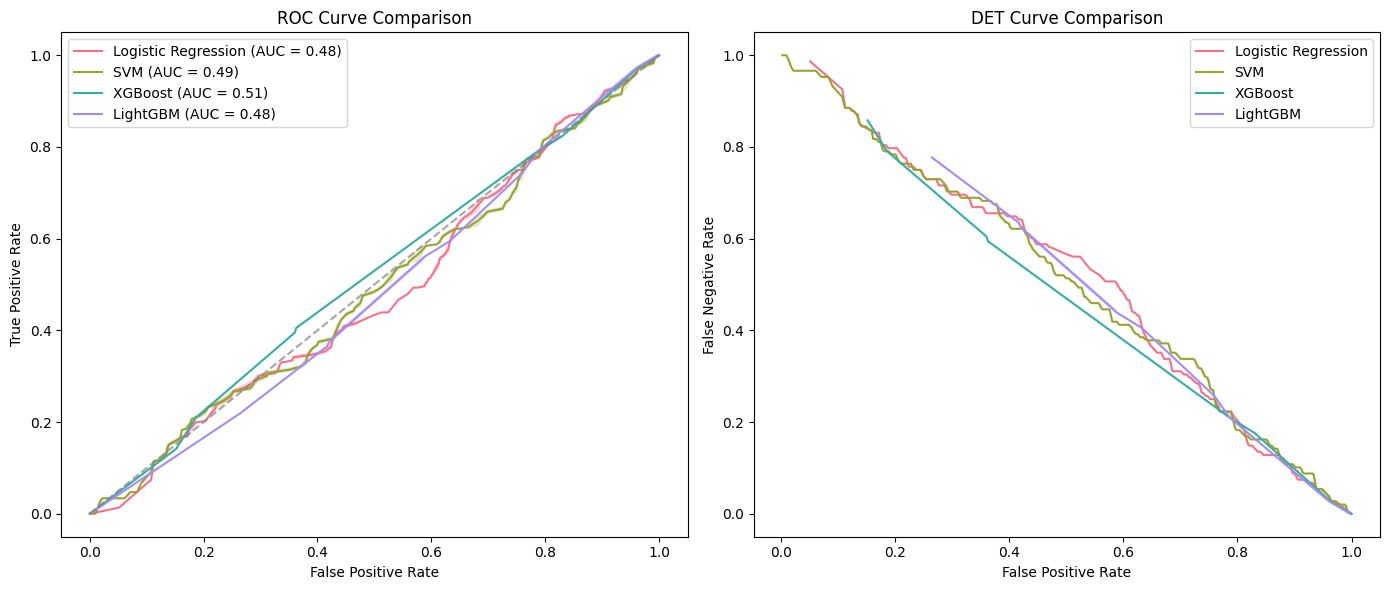

In [39]:
models = {
    "Logistic Regression": LogisticRegression(**logistic_regression_depression_best_hyperparameters, class_weight='balanced', random_state=42),
    "SVM": SVC(**svm_depression_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_depression_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_depression_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_depression = []

for i, (name, model) in enumerate(models.items()):
    model.fit(all_features_train, y_train['depression'])
    y_prob = model.predict_proba(all_features_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['depression'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['depression'], y_prob)

    models_list_depression.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['depression'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

Puntuaciones AUC (0,49–0,51): los modelos funcionan sólo ligeramente mejor que las conjeturas aleatorias, lo que indica una falta de características predictivas sólidas.

Rendimiento consistente en todos los modelos: ningún modelo supera significativamente a los demás

Información sobre la curva DET:

Las curvas DET muestran que las mejoras en FPR no mejoran drásticamente la FNR, lo que sugiere que los modelos están luchando con límites de decisión claros.


Guardamos la lista de la etiqueta “depression” para la siguiente sección.

In [40]:
models_list_depression

[LogisticRegression(C=0.01, class_weight='balanced', random_state=42),
 SVC(C=10, class_weight='balanced', kernel='linear', probability=True,
     random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LGBMClassifier(class_weight='balanced', learning_rate=0.01, num_leaves=

#### Graficas de la curva ROC y DET de modelos con etiqueta de “Anxiety”

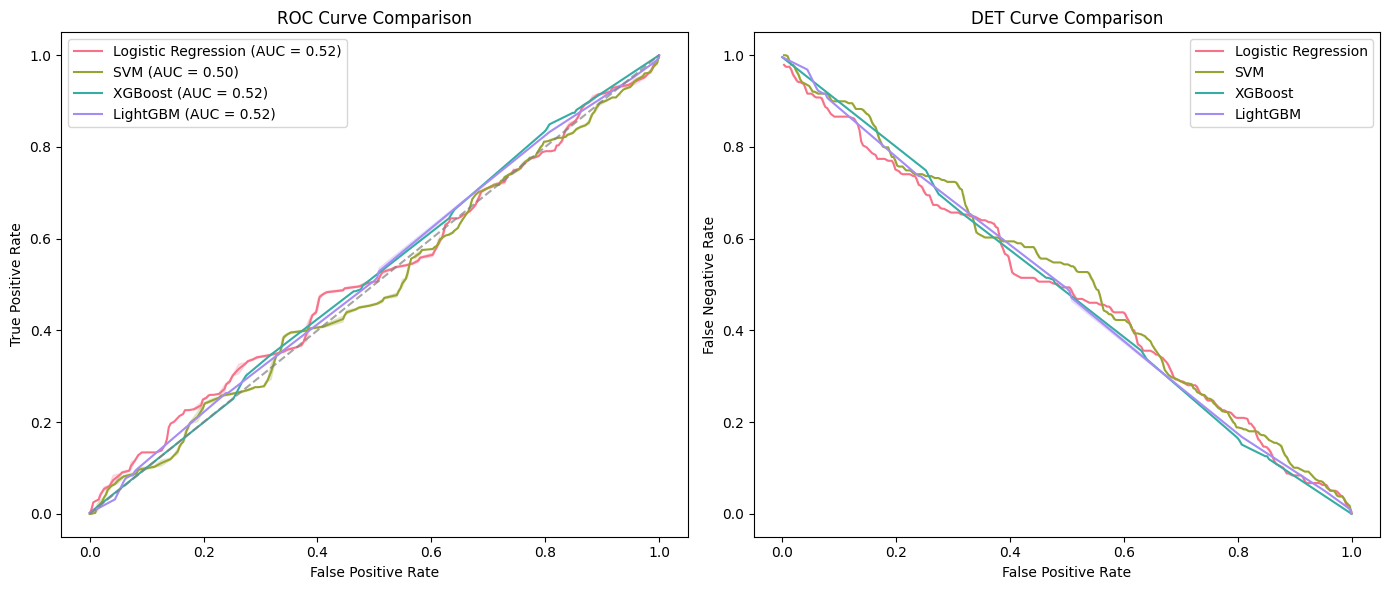

In [41]:
models = {
    "Logistic Regression": LogisticRegression(**logistic_regression_anxiety_best_hyperparameters, class_weight='balanced', random_state=42),
    "SVM": SVC(**svm_anxiety_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_anxiety_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_anxiety_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_anxiety = []

for i, (name, model) in enumerate(models.items()):
    model.fit(all_features_train, y_train['anxiety'])
    y_prob = model.predict_proba(all_features_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['anxiety'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['anxiety'], y_prob)

    models_list_anxiety.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['anxiety'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Guardamos la lista de la etiqueta anxiety para la siguiente sección.

In [42]:
models_list_anxiety

[LogisticRegression(C=1, class_weight='balanced', random_state=42),
 SVC(C=0.1, class_weight='balanced', probability=True, random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.3, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LGBMClassifier(class_weight='balanced', learning_rate=0.3, min_child_samples=5,
                

Perspectivas de la curva ROC:

AUC ligeramente superior (~0,50–0,51): aunque todavía son débiles, los modelos de ansiedad muestran una separación de clases ligeramente mejor en comparación con la depresión.

Los modelos basados en árboles funcionan ligeramente mejor: XGBoost y LightGBM tienen AUC más altas que la regresión logística y SVM, lo que sugiere que existen relaciones no lineales en los datos.

Información sobre la curva DET:

tasas de falsos positivos y falsos negativos se distribuyen de manera más uniforme, comparada con la grafica anterior en el label “depression”.


#### Graficas de la curva ROC y DET de modelos con etiqueta de "Stress"

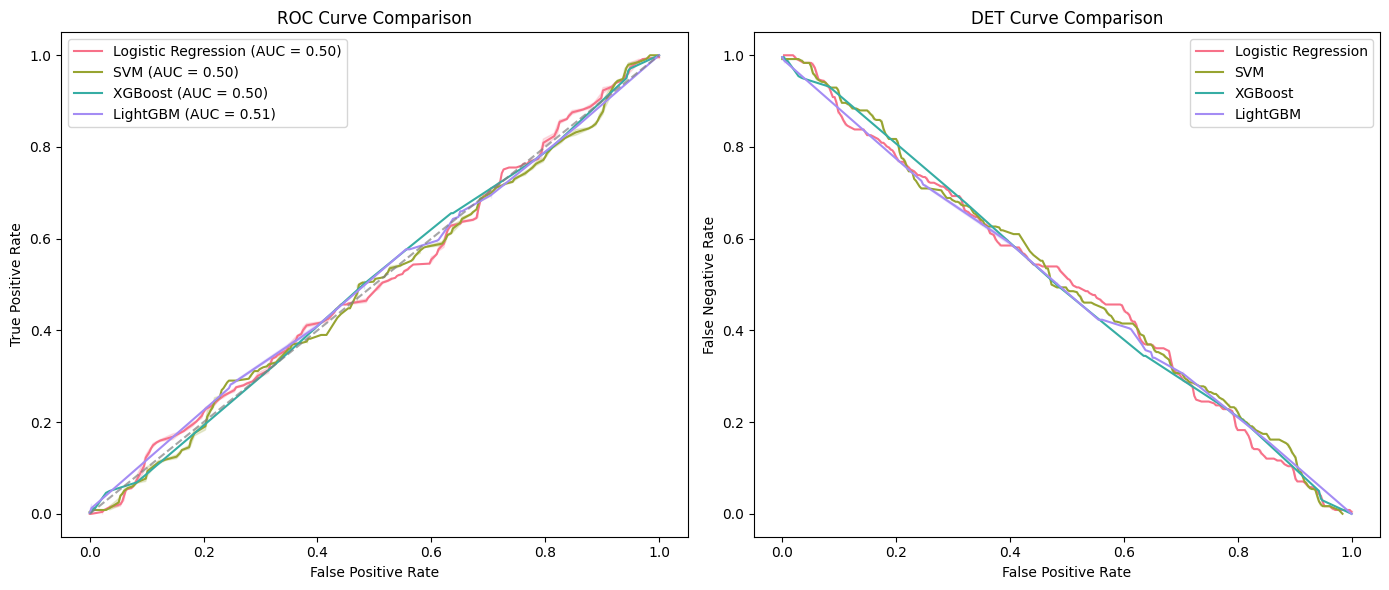

In [43]:
models = {
    "Logistic Regression": LogisticRegression(**logistic_regression_stress_best_hyperparameters, class_weight='balanced', random_state=42),
    "SVM": SVC(**svm_stress_best_hyperparameters, probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(**xgboost_stress_best_hyperparameters, random_state=42),
    "LightGBM": LGBMClassifier(**lightGBM_stress_best_hyperparameters, random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))
models_list_stress = []

for i, (name, model) in enumerate(models.items()):
    model.fit(all_features_train, y_train['stress'])
    y_prob = model.predict_proba(all_features_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['stress'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['stress'], y_prob)

    models_list_stress.append(model)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['stress'], y_prob):.2f})",
                 color=palette[i])

    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


Perspectivas de la curva ROC:

AUC similar a la ansiedad (~0,50–0,51): los modelos funcionan ligeramente mejor que las conjeturas aleatorias, pero aún carecen de un fuerte poder predictivo.

No hay un modelo destacado: a diferencia de la ansiedad, donde los modelos basados en árboles mejoraron ligeramente los resultados, todos los modelos parecen funcionar de manera similar para la detección del estrés.

Regresión logística y SVM bajan ligeramente en rendimiento.

Información sobre la curva DET:

Posible limitación del conjunto de datos: si ningún modelo mejora significativamente los resultados, es posible que las funciones no capturen patrones relacionados con el estrés de manera efectiva.


Guardamos la lista de la etiqueta "stress" para la siguiente sección.

In [44]:
models_list_stress


[LogisticRegression(C=1, class_weight='balanced', random_state=42),
 SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
     random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LGBMClassifier(class_weight='balanced', learning_rate=0.3, min_child_sample

No se observa sobre-entrenamiento pues la diferencia de accuracy entre test y train no es mayor al 3%. No se observa bajo-entrenamiento porque el porcentaje de accuracy es mayor a 0.56 que es el nuevo porcentaje de clase mayoritaria despues de las técnicas de bajo y sobre muestreo.

Dicho esto, se puede escoger el mejor modelo y seguir realizando mejoras con los datos y modelos para mejorar los resultados para futuras iteraciones.

# Análisis de características importantes

El análisis de características es crucial en la inteligencia artificial, el aprendizaje automático (ML) y la ciencia de datos porque ayuda a garantizar que el modelo utilice los datos correctos de la manera más efectiva:

*   al analizar las características, puede
identificar cuáles contribuyen más a las predicciones del modelo y cuáles son irrelevantes. Esto puede ayudar a mejorar la precisión y generalización del modelo seleccionando o diseñando las características más impactantes.

*   a veces, las características sin procesar deben transformarse, combinarse o dividirse para crear funciones más informativas. El análisis de características identifica áreas de mejora o la creación de nuevas características que podrían mejorar el rendimiento del modelo.


Transformarnos los datos de prueba similar a lo que sea realizo para los otros datos al entrenar el modelo

In [45]:
features_x_test = pd.DataFrame(X_text['caracteristica_0'].to_list())
features_y_test = pd.DataFrame(X_text['caracteristica_1'].to_list())

Xtest_processed = pd.concat([features_x_test, features_y_test], axis=1)

Crearemos una función que nos ayudara a crear gráficos de cada modelo que entrenaron anteriormente, al tener 3 etiquetas diferentes con 4 modelos entrenados cada uno tenesmo un total de 12 graficas, esto nos ayudara a facilitar el grafico de cada una

In [46]:
# Define a function that handles SHAP calculations and plotting for multiple models
def plot_shap_for_models(models, X_test, sample_size=50):
    warnings.filterwarnings("ignore", message="X does not have valid feature names")
    sample_data = X_test.values[:sample_size]
    shap_values_all = []

    # Loop through each model and calculate SHAP values
    for i, model in enumerate(models):

        if i < 2:
          predict_fn = lambda X: model.predict_proba(np.array(X).reshape(len(X), -1))[:, 0]

          sample_data = X_test.values[:sample_size]

          explainer = shap.KernelExplainer(predict_fn, sample_data)
          shap_values = explainer.shap_values(sample_data)

          shap_values_all.append((i, shap_values))

        elif i >= 2:
          explainer = shap.TreeExplainer(model)
          shap_values = explainer.shap_values(X_test.values[:sample_size])

          shap_values_all.append((i, shap_values))

    # Plot all SHAP values together
    for model_idx, shap_values in shap_values_all:
        shap.summary_plot(shap_values, sample_data, show=False)
        if model_idx == 0: plt.title(f'Logistic Regression Model')
        elif model_idx == 1: plt.title(f'SVC Model')
        elif model_idx == 2: plt.title(f'XGB Classifier Model')
        elif model_idx == 3: plt.title(f'GBM Classifier Model')
        plt.show()

Graficas de caracteristicas SHAP para modelos con etiqueta de "depression"

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


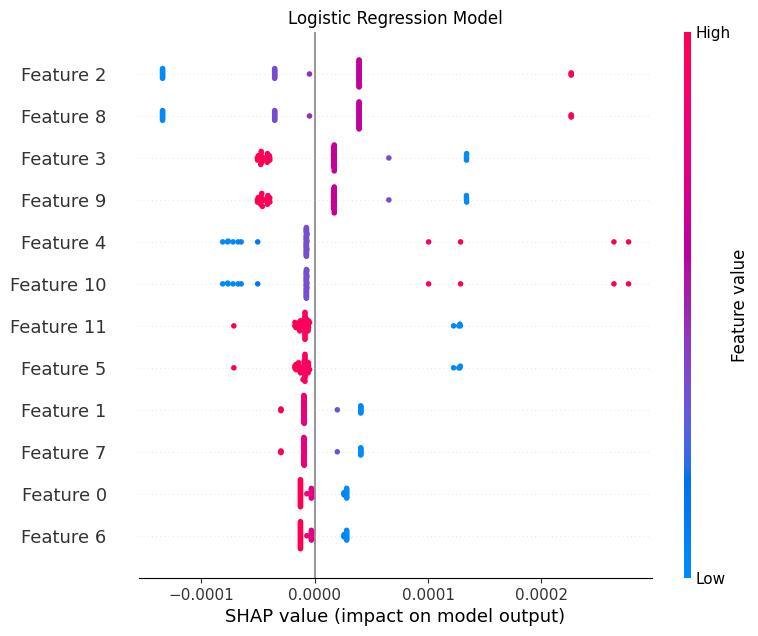

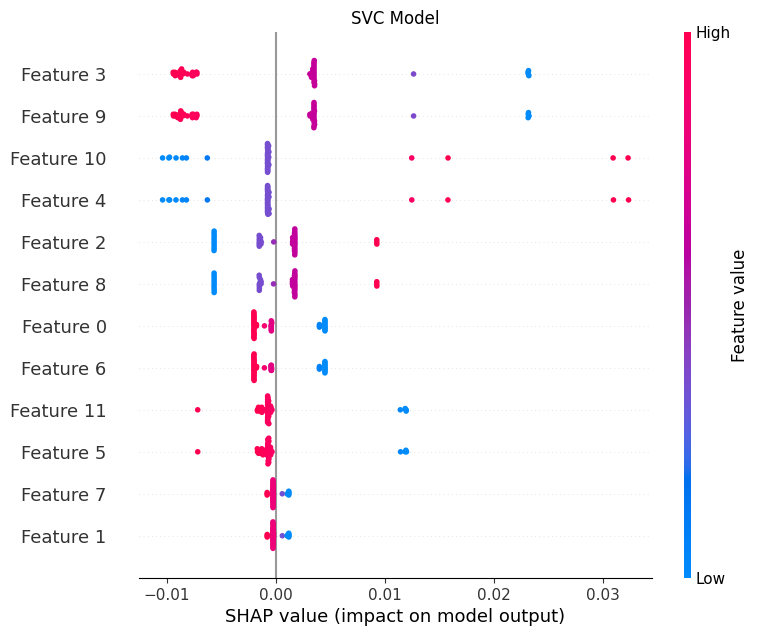

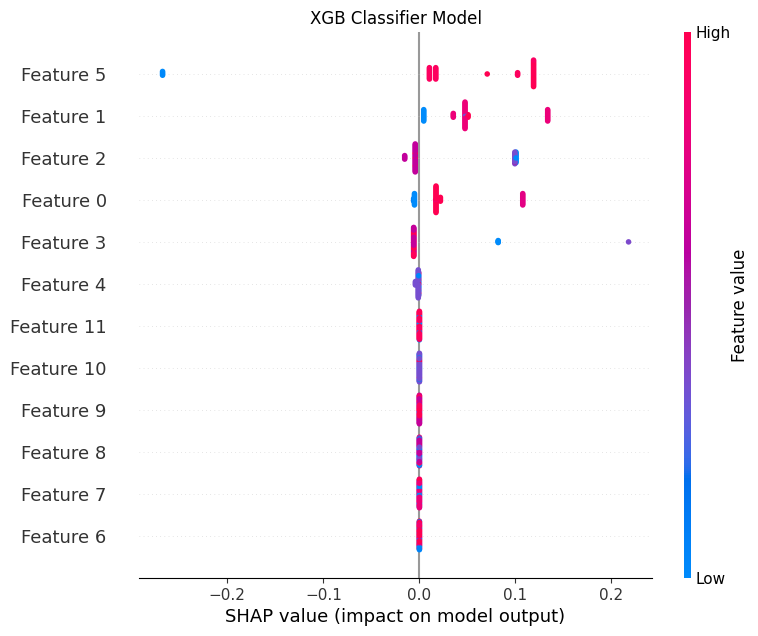

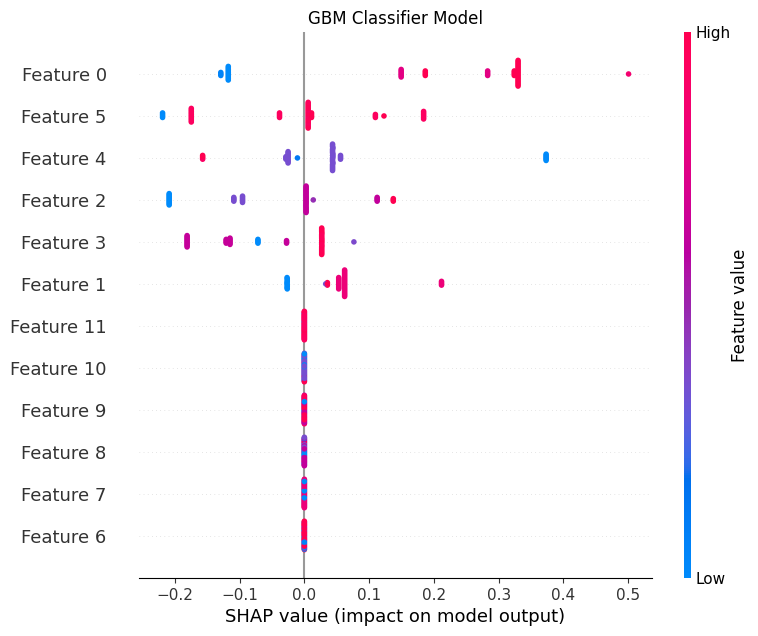

In [47]:
plot_shap_for_models(models_list_depression, Xtest_processed)

Los modelos basados en árboles muestran una ligera priorización: LightGBM y XGBoost priorizan ligeramente algunas características, pero su impacto no es lo suficientemente fuerte como para mejorar drásticamente el AUC.

los valores SHAP fluctúan significativamente entre muestras, lo que significa que la misma característica a veces aumenta y otras disminuye la probabilidad de depresión.


Graficas de caracteristicas SHAP para modelos con etiqueta de "anxiety"

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


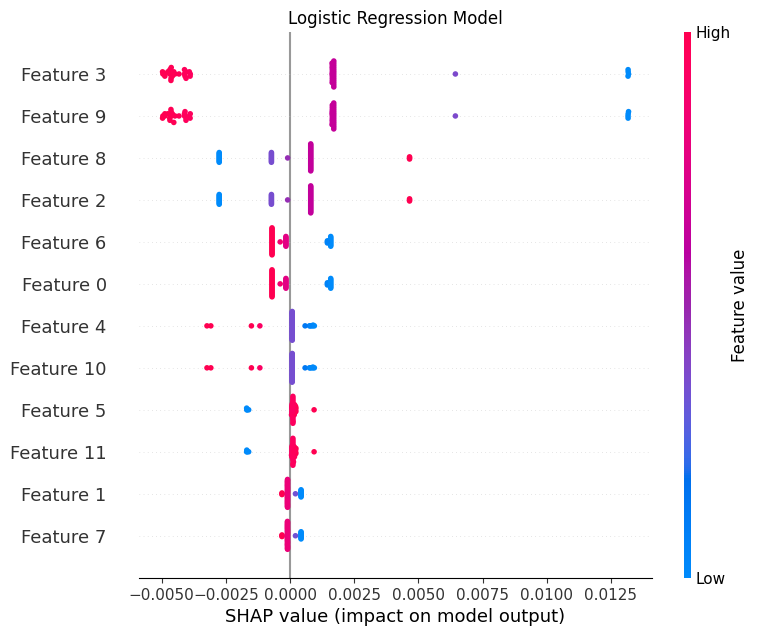

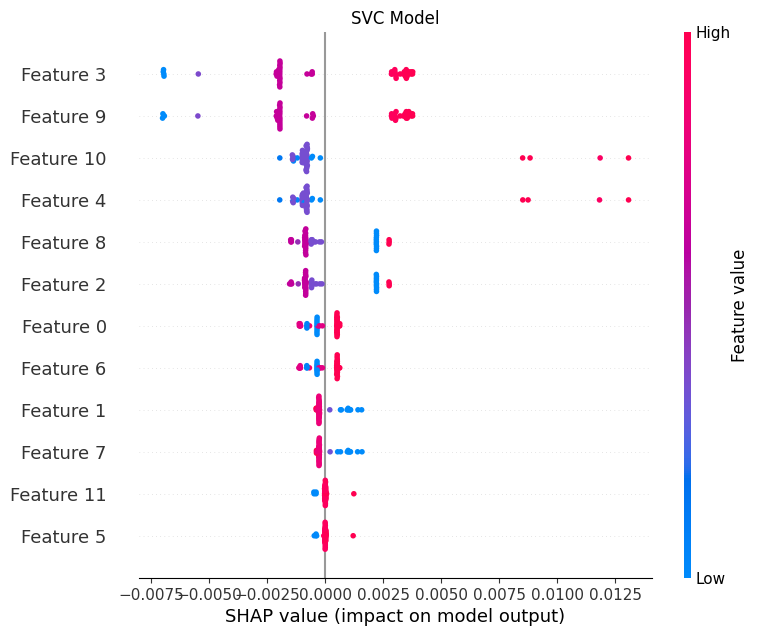

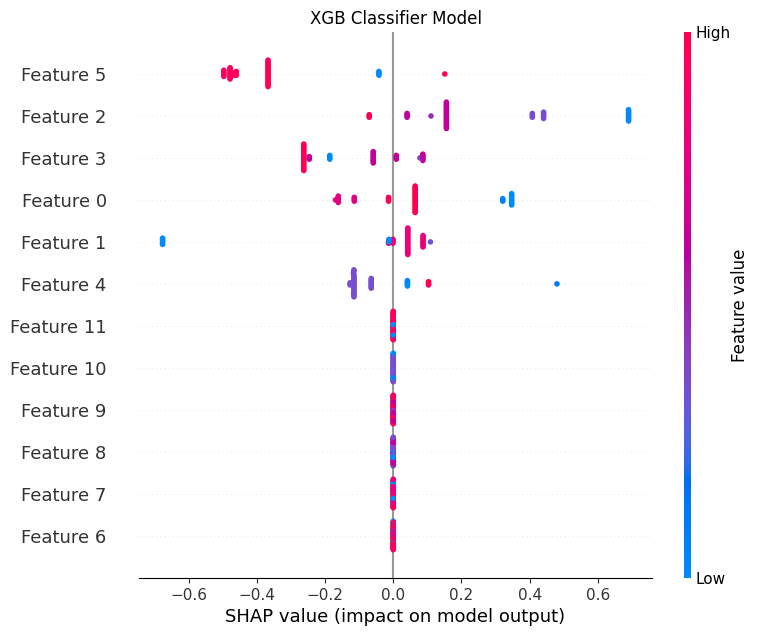

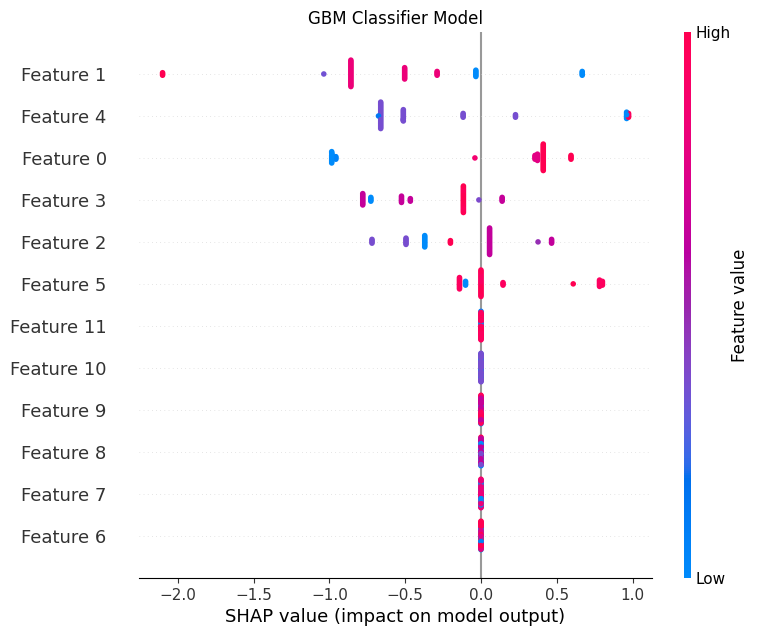

In [48]:
plot_shap_for_models(models_list_anxiety, Xtest_processed)

los valores SHAP indican una distribución más uniforme de la importancia de las características, lo que significa que el modelo considera múltiples características en lugar de depender de una única dominante.

Los modelos basados en árboles muestran cierta priorización de características: a diferencia de la depresión, LightGBM y XGBoost resaltan un pequeño conjunto de características como más impactantes, lo que sugiere una relación más estructurada.

algunas características contribuyen positivamente a la clasificación de la ansiedad en una muestra pero negativamente en otra.


Graficas de caracteristicas SHAP para modelos con etiqueta de "stress"

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


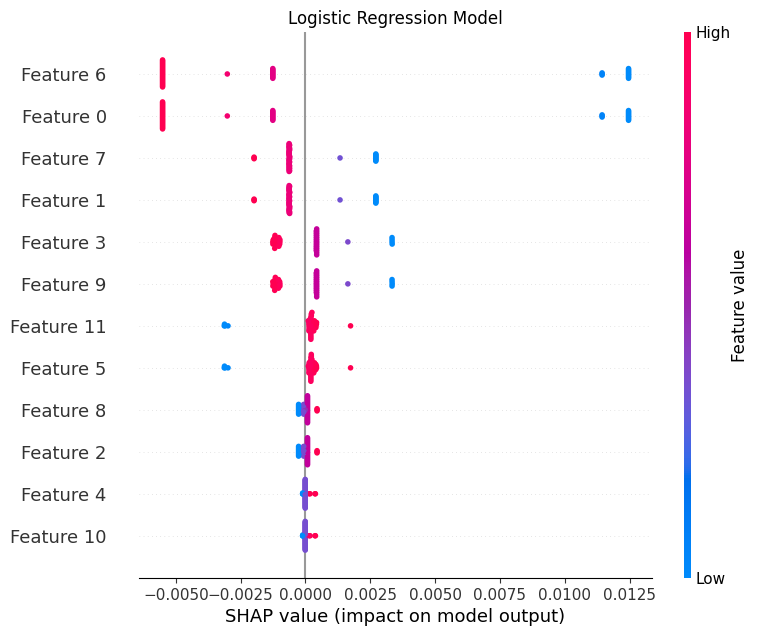

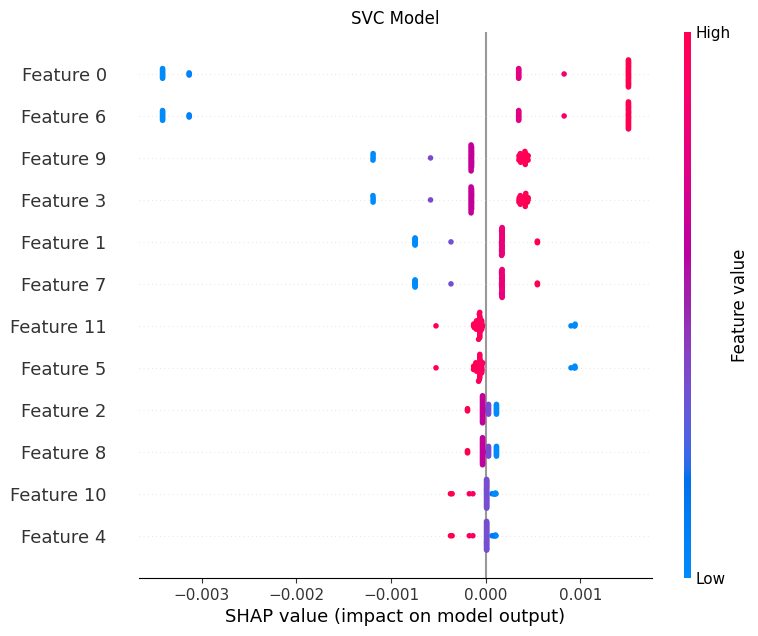

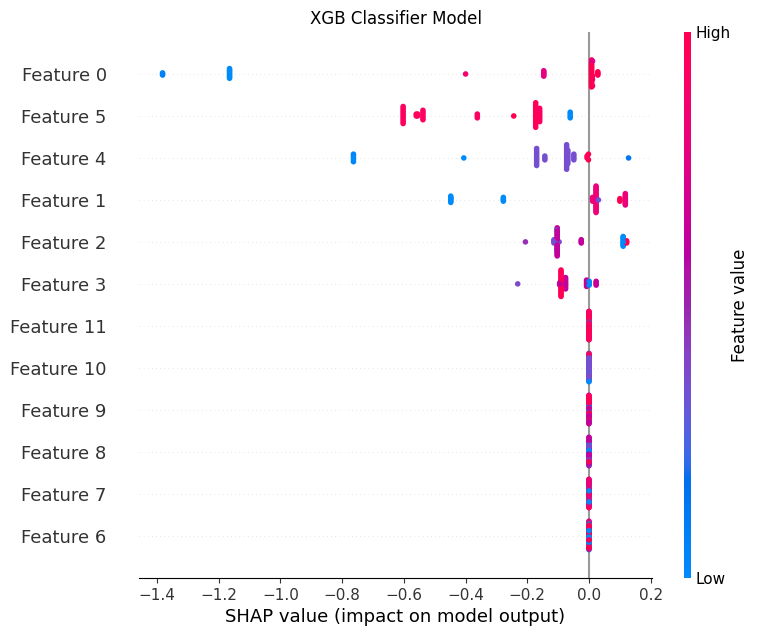

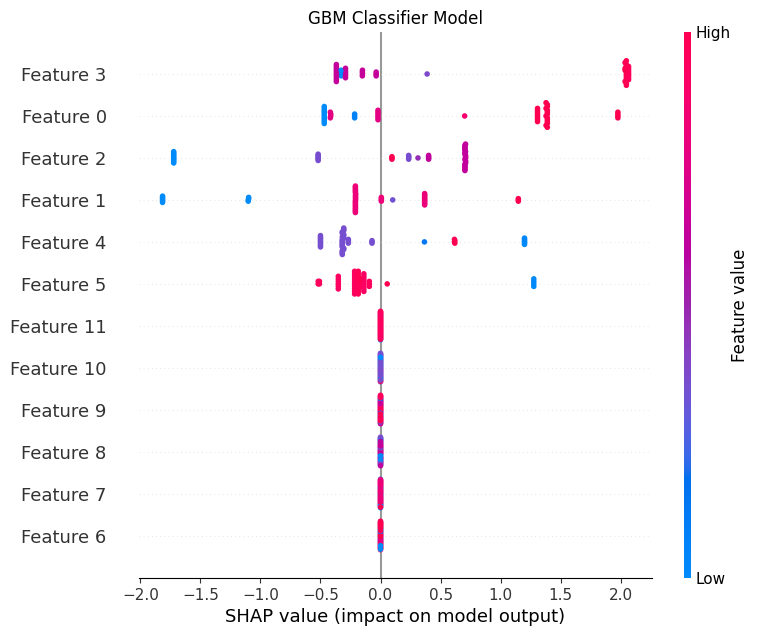

In [49]:
plot_shap_for_models(models_list_stress, Xtest_processed)

La mayoría de las características tienen la misma influencia: ninguna característica domina en el análisis SHAP, lo que significa que la clasificación del estrés se basa en una combinación de señales más débiles.

Los modelos basados en árboles y la regresión logística muestran patrones similares: a diferencia de la ansiedad, donde los modelos basados  en árboles brindan mejores conocimientos, aquí todos los modelos distribuyen la importancia de las características de manera similar


# Conclusiones

**Equilibrio de clases:**

*   Las etiquetas de ansiedad y estrés están relativamente equilibradas, mientras que la depresión está ligeramente desequilibrada pero dentro de un rango aceptable (~27% de clase positiva).

*   No hubo problemas graves de desequilibrio de clases, pero se utilizó SMOTE para equilibrar los datos lo más posible.

**Métrica:**

*   Para la métrica se realizo el uso de graficas de curva ROC y DET para observación del modelo a petición de los Doctores.

*   De manera general, por contexto del negocio, precisión puede ser una mejor métrica, dada la importancia de reducir los falsos positivos en las evaluaciones psicológicas.

**Modelos/Algoritmos:**

*   Se probaron regresión logística, SVM, XGBoost y LightGBM.

*   Ninguno mostró una gran superioridad, pero los modelos basados en árboles (XGBoost, LightGBM) superaron ligeramente a otros.

**Análisis de sobre/sub-ajuste:**

*   No se observó sobreajuste, de manera general.

*   Es posible que se necesite más selección de funciones o complejidad del modelo, dependiendo de el alcance y las necesidades del negocio.

**Análisis de características:**

*   El análisis SHAP resalta la importancia de las características, existe posibilidad que sea necesario perfeccionar las funciones y el procesamiento de datos o probar usando más características y ver si eso mejora el rendimiento de los modelos.


# Referencias

S, G., Anand, A., Vijayvargiya, A., M, P., Moorthy, V., Kumar, S., & S, H. B. S. (2022, July 12). Emosens: Emotion recognition based on sensor data analysis using LIGHTGBM. arXiv.org. https://arxiv.org/abs/2207.14640

Costa, R. (2022). The CRISP-ML Methodology: A Step-by-Step Approach to Real-World Machine Learning Projects.

Piccini, N. (2023, julio 19). 101 machine learning algorithms for data science with cheat sheets. Data Science Dojo.